In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/Data/train_age_dataset.csv')
len(train)

488877

In [5]:
test = pd.read_csv('/content/drive/MyDrive/Datasets/Data/test_age_dataset.csv')
len(test)

54320

In [6]:
sample = pd.read_csv('/content/drive/MyDrive/Datasets/Data/sample_submission.csv')
sample.head()

,prediction
0,1
1,1
2,1
3,1
4,1


## Cleaning

In [7]:
train.isnull().sum()

Unnamed: 0                         0
userId                             0
tier                               0
gender                             0
following_rate                     0
followers_avg_age                  0
following_avg_age                  0
max_repetitive_punc                0
num_of_hashtags_per_action         0
emoji_count_per_action             0
punctuations_per_action            0
number_of_words_per_action         0
avgCompletion                      0
avgTimeSpent                       0
avgDuration                        0
avgComments                        0
creations                          0
content_views                      0
num_of_comments                    0
weekends_trails_watched_per_day    0
weekdays_trails_watched_per_day    0
slot1_trails_watched_per_day       0
slot2_trails_watched_per_day       0
slot3_trails_watched_per_day       0
slot4_trails_watched_per_day       0
avgt2                              0
age_group                          0
d

In [8]:
test.isnull().sum()

Unnamed: 0                         0
userId                             0
tier                               0
gender                             0
following_rate                     0
followers_avg_age                  0
following_avg_age                  0
max_repetitive_punc                0
num_of_hashtags_per_action         0
emoji_count_per_action             0
punctuations_per_action            0
number_of_words_per_action         0
avgCompletion                      0
avgTimeSpent                       0
avgDuration                        0
avgComments                        0
creations                          0
content_views                      0
num_of_comments                    0
weekends_trails_watched_per_day    0
weekdays_trails_watched_per_day    0
slot1_trails_watched_per_day       0
slot2_trails_watched_per_day       0
slot3_trails_watched_per_day       0
slot4_trails_watched_per_day       0
avgt2                              0
dtype: int64

# WHY ARE THERE NO NULL VALUES

In [9]:
train.head()

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,265153,48958844,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.463330,34.160000,53.996091,0,0.000000,0.200000,0.0,0.041667,0.025000,0.0,0.000000,0.175000,0.033333,0.0,1
1,405231,51100441,2,2,0.0,0.0,0.0,0,0.0,0.0,0.076923,0.153846,0.429468,15.285714,96.231625,0,0.008475,0.093220,0.0,0.012712,0.018644,0.0,0.084746,0.000000,0.033898,82.5,2
2,57867,6887426,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.341657,22.000000,83.051415,0,0.000000,0.002786,0.0,0.000000,0.000557,0.0,0.002786,0.000000,0.000000,0.0,1
3,272618,50742404,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.005735,3.000000,523.080000,0,0.000000,0.008403,0.0,0.000000,0.001681,0.0,0.000000,0.000000,0.008403,0.0,1
4,251123,45589200,2,2,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.456549,12.333333,53.766640,0,0.000000,0.204918,0.0,0.000000,0.049180,0.0,0.008197,0.057377,0.180328,0.0,1


Oh looks like the null values have been filled with zeros

In [10]:
unnamed = train['Unnamed: 0'].value_counts()
unnamed.value_counts()

1    488877
Name: Unnamed: 0, dtype: int64

Dropping this column, it's redundant

Checking the zero null thing

In [11]:
traintest = pd.concat([train, test])
traintest

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,265153,48958844,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.463330,34.160000,53.996091,0,0.000000,0.200000,0.000000,0.041667,0.025000,0.000000,0.000000,0.175000,0.033333,0.000,1.0
1,405231,51100441,2,2,0.000000,0.000000,0.000000,0,0.0,0.0,0.076923,0.153846,0.429468,15.285714,96.231625,0,0.008475,0.093220,0.000000,0.012712,0.018644,0.000000,0.084746,0.000000,0.033898,82.500,2.0
2,57867,6887426,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.341657,22.000000,83.051415,0,0.000000,0.002786,0.000000,0.000000,0.000557,0.000000,0.002786,0.000000,0.000000,0.000,1.0
3,272618,50742404,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.005735,3.000000,523.080000,0,0.000000,0.008403,0.000000,0.000000,0.001681,0.000000,0.000000,0.000000,0.008403,0.000,1.0
4,251123,45589200,2,2,0.000000,0.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.456549,12.333333,53.766640,0,0.000000,0.204918,0.000000,0.000000,0.049180,0.000000,0.008197,0.057377,0.180328,0.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54315,301257,56503645,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.563077,12.137931,38.427446,0,0.000000,0.523364,0.000000,0.000000,0.108411,0.000000,0.000000,0.140187,0.401869,0.000,NaN
54316,39167,39840927,1,1,0.177419,1.666667,2.210526,0,0.0,0.0,0.000000,0.105263,0.288746,7.092593,72.958604,0,0.016129,0.435484,0.000000,0.072581,0.058065,0.000000,0.040323,0.104839,0.290323,140.325,NaN
54317,471826,68398375,2,1,0.048387,0.000000,0.000000,3,0.0,0.0,0.000000,0.142857,0.630975,10.466667,20.349232,3,0.016129,0.935484,0.048387,0.209677,0.158065,0.000000,0.435484,0.048387,0.725806,186.000,NaN
54318,13839,51709440,1,2,0.000000,0.000000,0.000000,0,0.0,0.0,0.000000,0.000000,0.387859,6.571429,37.704650,0,0.000000,0.177966,0.000000,0.088983,0.000000,0.000000,0.000000,0.000000,0.177966,0.000,NaN


In [12]:
traintest.groupby(['following_rate']).size()

following_rate
0.000000      345156
0.000686           1
0.000689           1
0.000704           1
0.000772           2
               ...  
426.504000         1
488.362205         1
563.631147         1
685.277778         1
895.304000         1
Length: 16377, dtype: int64

In [13]:
traintest['Majority Followers'] = np.round(traintest['followers_avg_age'])
traintest['Majority Following'] = np.round(traintest['following_avg_age'])

In [14]:
traintest.groupby(['content_views']).size()

content_views
0.000873     1
0.000883     1
0.000887     1
0.000895     1
0.000909     1
            ..
35.801587    1
37.206349    1
39.966387    1
39.991935    1
75.662281    1
Length: 33941, dtype: int64

In [15]:
bins = pd.IntervalIndex.from_tuples([(0, 0.01), (0.01, 0.1), (0.1, 1), (1,10), (10,100)])
traintest['view_binned'] = pd.cut(train['content_views'], bins = bins)
traintest.groupby(['view_binned']).size()

view_binned
(0.0, 0.01]       45002
(0.01, 0.1]      198281
(0.1, 1.0]       250142
(1.0, 10.0]       49215
(10.0, 100.0]       557
dtype: int64

In [16]:
from sklearn.preprocessing import LabelEncoder
view_le = LabelEncoder()
traintest['view_binned'] = view_le.fit_transform(traintest['view_binned'])
traintest.groupby(['view_binned']).size()

view_binned
0     45002
1    198281
2    250142
3     49215
4       557
dtype: int64

## Model Testing chumma

In [17]:
from sklearn.metrics import f1_score
import lightgbm as lgb

In [18]:
train = traintest[:488877]
test = traintest[488877:]

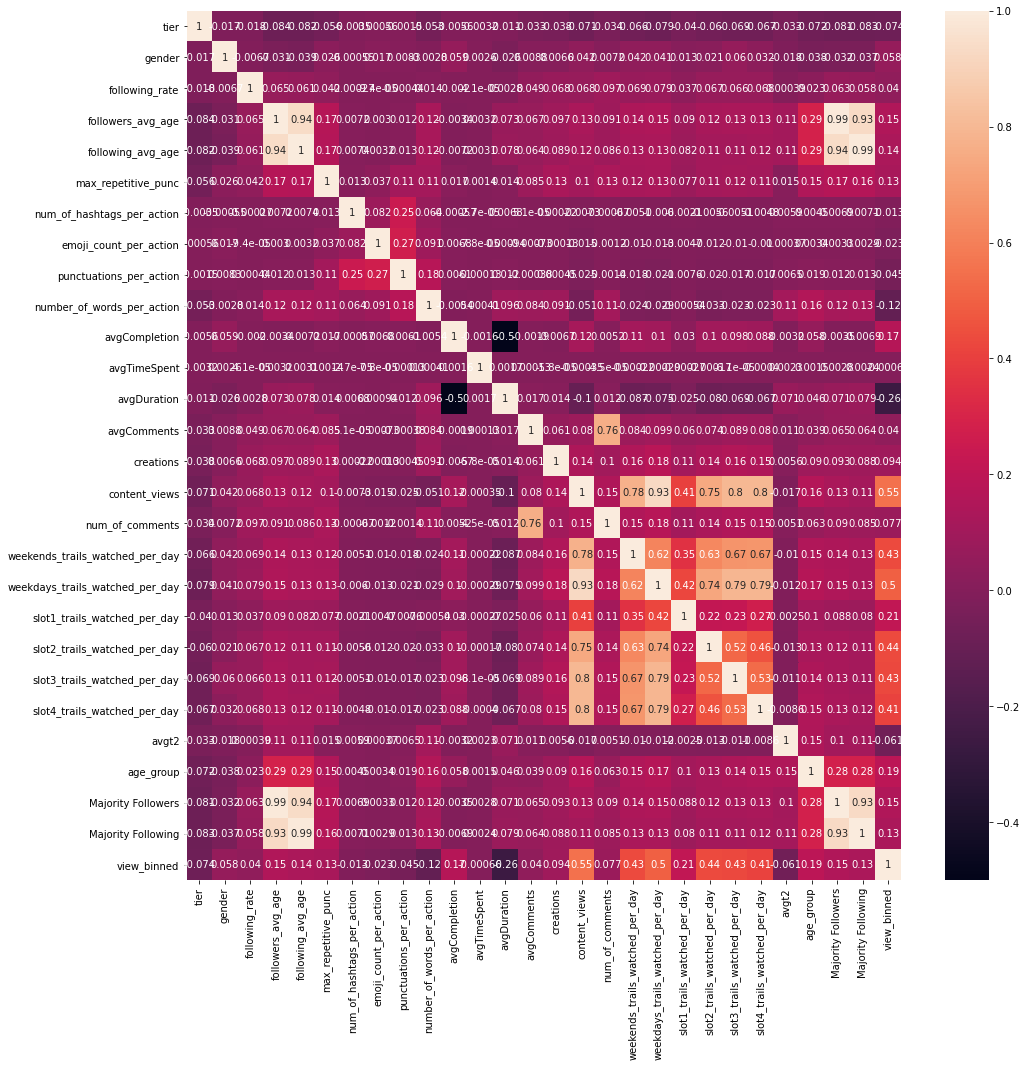

In [19]:
plt.figure(figsize = (16,16))
sns.heatmap(train.drop(['Unnamed: 0', 'userId'], axis = 1).corr(), annot = True)
plt.show()

In [82]:
X = train.drop(['Unnamed: 0', 'userId', 'age_group', 'Majority Followers', 'Majority Following', 'view_binned'], axis = 1)
Y = train['age_group']

In [83]:
from sklearn.model_selection import train_test_split
X_Train, X_CV, Y_Train, Y_CV = train_test_split(X, Y, test_size = 0.15, random_state = 0)

In [84]:
clf = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.17, n_jobs=-1, is_unbalanced = True, objective = 'multiclassova')
clf.fit(X_Train, Y_Train, early_stopping_rounds = 200, eval_set = [(X_Train, Y_Train), (X_CV, Y_CV)], verbose = True)

[1]	training's multi_logloss: 0.929205	valid_1's multi_logloss: 0.926768
Training until validation scores don't improve for 200 rounds.
[2]	training's multi_logloss: 0.846962	valid_1's multi_logloss: 0.844747
[3]	training's multi_logloss: 0.789311	valid_1's multi_logloss: 0.787469
[4]	training's multi_logloss: 0.744769	valid_1's multi_logloss: 0.742993
[5]	training's multi_logloss: 0.710799	valid_1's multi_logloss: 0.709174
[6]	training's multi_logloss: 0.684515	valid_1's multi_logloss: 0.682727
[7]	training's multi_logloss: 0.663232	valid_1's multi_logloss: 0.661535
[8]	training's multi_logloss: 0.645939	valid_1's multi_logloss: 0.644175
[9]	training's multi_logloss: 0.631991	valid_1's multi_logloss: 0.630405
[10]	training's multi_logloss: 0.621234	valid_1's multi_logloss: 0.619859
[11]	training's multi_logloss: 0.612001	valid_1's multi_logloss: 0.610734
[12]	training's multi_logloss: 0.60329	valid_1's multi_logloss: 0.602169
[13]	training's multi_logloss: 0.596681	valid_1's multi_log

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalanced=True, learning_rate=0.17,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective='multiclassova', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [85]:
pred = clf.predict(X_CV)
print(f1_score(Y_CV, pred, average = 'weighted'))

0.748567341784831


In [86]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000,
                    learning_rate=0.17, n_jobs=-1, objective = 'multiclassova')
xgb.fit(X_Train, Y_Train, early_stopping_rounds = 200, eval_set = [(X_Train, Y_Train), (X_CV, Y_CV)],eval_metric = 'mlogloss', verbose = True)

[0]	validation_0-mlogloss:1.2181	validation_1-mlogloss:1.21778
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 200 rounds.
[1]	validation_0-mlogloss:1.10315	validation_1-mlogloss:1.10206
[2]	validation_0-mlogloss:1.01716	validation_1-mlogloss:1.01468
[3]	validation_0-mlogloss:0.950996	validation_1-mlogloss:0.947954
[4]	validation_0-mlogloss:0.896644	validation_1-mlogloss:0.893096
[5]	validation_0-mlogloss:0.85161	validation_1-mlogloss:0.849693
[6]	validation_0-mlogloss:0.817549	validation_1-mlogloss:0.81491
[7]	validation_0-mlogloss:0.788785	validation_1-mlogloss:0.785207
[8]	validation_0-mlogloss:0.7642	validation_1-mlogloss:0.761482
[9]	validation_0-mlogloss:0.744702	validation_1-mlogloss:0.740938
[10]	validation_0-mlogloss:0.72764	validation_1-mlogloss:0.72386
[11]	validation_0-mlogloss:0.713278	validation_1-mlogloss:0.709931
[12]	validation_0-mlogloss:0.701507	validation_1-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.17, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [87]:
pred = xgb.predict(X_CV)
print(f1_score(Y_CV, pred, average = 'weighted'))

0.7501764243438218


In [71]:
!pip install catboost
from catboost import CatBoostClassifier
class_weights = {1:1, 2:5, 3:5, 4:5}
cat = CatBoostClassifier(iterations = 1000, learning_rate = 0.25, class_weights = class_weights)
cat.fit(X_Train, Y_Train, use_best_model = True, eval_set = [(X_CV, Y_CV)], verbose = True)

0:	learn: 1.2031330	test: 1.2021733	best: 1.2021733 (0)	total: 474ms	remaining: 7m 53s
1:	learn: 1.1207165	test: 1.1193675	best: 1.1193675 (1)	total: 955ms	remaining: 7m 56s
2:	learn: 1.0560412	test: 1.0538180	best: 1.0538180 (2)	total: 1.47s	remaining: 8m 9s
3:	learn: 1.0219576	test: 1.0200972	best: 1.0200972 (3)	total: 1.94s	remaining: 8m 2s
4:	learn: 0.9982376	test: 0.9964372	best: 0.9964372 (4)	total: 2.38s	remaining: 7m 53s
5:	learn: 0.9787666	test: 0.9769439	best: 0.9769439 (5)	total: 2.88s	remaining: 7m 56s
6:	learn: 0.9599938	test: 0.9580036	best: 0.9580036 (6)	total: 3.4s	remaining: 8m 2s
7:	learn: 0.9506957	test: 0.9489280	best: 0.9489280 (7)	total: 3.83s	remaining: 7m 54s
8:	learn: 0.9433911	test: 0.9417777	best: 0.9417777 (8)	total: 4.28s	remaining: 7m 51s
9:	learn: 0.9312962	test: 0.9294064	best: 0.9294064 (9)	total: 4.79s	remaining: 7m 53s
10:	learn: 0.9220944	test: 0.9200736	best: 0.9200736 (10)	total: 5.3s	remaining: 7m 56s
11:	learn: 0.9183602	test: 0.9164096	best: 0.9

KeyboardInterrupt: ignored

In [95]:
pred = cat.predict(X_CV)
print(f1_score(Y_CV, pred, average = 'weighted'))

CatBoostError: ignored

In [92]:
lgb_pred = clf.predict_proba(test.drop(['Unnamed: 0', 'userId', 'age_group', 'Majority Followers', 'Majority Following', 'view_binned'], axis = 1))
xgb_pred = xgb.predict_proba(test.drop(['Unnamed: 0', 'userId', 'age_group', 'Majority Followers', 'Majority Following', 'view_binned'], axis = 1))
ensemble = (0.748*lgb_pred + 0.7501*xgb_pred)/(0.748 + 0.7501)
#ensemble = ensemble.argmax() + 1
test_pred = pd.DataFrame(ensemble)
test_pred = test_pred.idxmax(axis = 1) + 1
test_pred.columns = ['prediction']

In [93]:
test_pred.head()

0    1
1    1
2    1
3    2
4    1
dtype: int64

In [94]:
test_pred.to_csv('/content/drive/MyDrive/Datasets/Data/Preds/Submission6.csv', index = False, header = True)